# Business Understanding

## Problem Statement
Traffic accidents in Chicago causes 1 death in every 3 days, and 5 serious injuries in everyday.

Only between 2010-2014, 554 people had been killed and 9480 had been seriously injured on those accidents.

## End Goal
The end goal is to 
- identify where we can *reduce* risks, and/or *educate* the public better on potential risks 
- develop a model *to predict* the probability of future accidents and fatal/total injuries. 

<a id='top'></a>
# Exploratory Data Analysis Framework 

We should evaluate the quality of data at our disposal and demonstrate which factors have the highest impact on the model decisions.

- [Data Description](#data_description)
- [Data Quality Assessment](#data_quality)
- [Overview of Data Distributions](#data_distributions)
- [Analysis of Geolocation, Time Series and Categorical Data](#data_different)
- [Correlation Analysis](#data_correlation)

In [27]:
import timeit
start_time = timeit.default_timer()  #timestamp to calculate total runtime

import pandas as pd
import numpy as np

import researchpy as rp
import missingno as msno

import seaborn as sns
import matplotlib.pyplot as plt

import itertools
import scipy.stats as ss

%matplotlib inline
pd.set_option('display.max_columns', None)  # prevent output trancation
sns.set()  # change plot styling from Matlab's 90s feel to today's Seaborn.

In [28]:
# File Directories
path_crashes = 'crashes.sample2020.csv'
path_vehicles = 'vehicles.sample.csv'
path_people = 'people.sample.csv'

# Columns that will be read as categorical
# The fromkeys() method returns a dictionary with the specified keys and the specified value
categoricals_crashes = dict.fromkeys(
    [5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 35],
    'category')
categoricals_vehicles = dict.fromkeys([5, 9, 10, 11, 13, 14, 15, 16, 17, 38],
                                      'category')
categoricals_people = dict.fromkeys(
    [7, 8, 10, 12, 13, 14, 15, 17, 21, 22, 23, 27], 'category')

# Import samples
crashes = pd.read_csv(
    path_crashes,
    parse_dates=["CRASH_DATE", "CRASH_DATE_EST_I", "DATE_POLICE_NOTIFIED"],
    low_memory=False,
    dtype=categoricals_crashes)
vehicles = pd.read_csv(path_vehicles,
                       parse_dates=["CRASH_DATE"],
                       low_memory=False,
                       dtype=categoricals_vehicles)
people = pd.read_csv(path_people,
                     parse_dates=["CRASH_DATE"],
                     low_memory=False,
                     dtype=categoricals_people)

<a id='data_description'></a>
## Data Description

*[Back to Top](#top)*

Number of observations and features in samples.

In [29]:
# dimensions of sample datasets
print(crashes.shape)
print(vehicles.shape)
print(people.shape)

(33408, 49)
(75673, 72)
(82049, 30)


### Data Information

Data Dictionaries and important explanations of datasets provided by City of Chicago.

- [`Crashes`](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if)

> *\"...If any new or updated information on a crash is received, the reporting officer may amend the crash report at a later time.\"*

> *\"As per Illinois statute, only crashes with a property damage value of **$1,500 or more or involving bodily injury to any person(s)** and ..., are considered reportable crashes. However, CPD records every reported traffic crash event, regardless of the statute of limitations, ..."*

---

- [`Vehicles`](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Vehicles/68nd-jvt3)

> *\"Each mode of transportation involved in a crash is a **“unit”** and get one entry here. Each vehicle, each pedestrian, each motorcyclist, and each bicyclist **is considered an independent unit** that can have a trajectory separate from the other units.\"*

> *\"Vehicle information can be linked back to Crash data using the **CRASH_RECORD_ID** field.\"* 

> *\"Data for occupants who do not make up an independent unit, typically **drivers and passengers**, are available in the **People** table.\"*

> *\"Since this dataset is a combination of vehicles, pedestrians, and pedal cyclists not all columns are applicable to each record. Look at the **Unit Type** field to determine what additional data may be available for that record.\"*

---
 
- [`People`](https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d)

> *\"Each record corresponds to **an occupant in a vehicle** listed in the Crash dataset. Some people involved in a crash **may not** have been an occupant in a motor vehicle, but may have been a pedestrian, bicyclist, or using another non-motor vehicle mode of transportation.\"*

> *\"Fatalities that occur after the initial reports are typically updated in these records **up to 30 days** after the date of the crash.\"*

> *\"Person data can be linked with the Crash and Vehicle dataset using the **CRASH_RECORD_ID** field.\"* 

> *\"A vehicle can have multiple occupants and hence have a **one to many** relationship between Vehicle and Person dataset. However, a pedestrian is a **“unit”** by itself and have a **one to one** relationship between the Vehicle and Person table.\"*

### First Inspection

#### `crashes`

In [30]:
crashes.head()

,CRASH_RECORD_ID,RD_NO,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,REPORT_TYPE,CRASH_TYPE,INTERSECTION_RELATED_I,NOT_RIGHT_OF_WAY_I,HIT_AND_RUN_I,DAMAGE,DATE_POLICE_NOTIFIED,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,STREET_NO,STREET_DIRECTION,STREET_NAME,BEAT_OF_OCCURRENCE,PHOTOS_TAKEN_I,STATEMENTS_TAKEN_I,DOORING_I,WORK_ZONE_I,WORK_ZONE_TYPE,WORKERS_PRESENT_I,NUM_UNITS,MOST_SEVERE_INJURY,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,0211e1f766f3940dfa87375661d25b716655e908c320cc...,JC301403,NaN,2019-06-11 08:40:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,DIVIDED - W/MEDIAN BARRIER,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,Y,NaN,NaN,"$501 - $1,500",2019-06-11 09:05:00,UNABLE TO DETERMINE,NOT APPLICABLE,50,E,GARFIELD BLVD,225,NaN,NaN,NaN,NaN,NaN,NaN,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,3.0,0.0,8,3,6,41.794779,-87.623828,POINT (-87.623828038036 41.794778764028)
1,02e2ed3606a50dda185f5e97c57a45552087d6fbea1c4b...,JB256393,NaN,2018-05-09 11:30:00,25,NO CONTROLS,NO CONTROLS,RAIN,DAYLIGHT,ANGLE,NOT DIVIDED,2.0,STRAIGHT AND LEVEL,WET,NO DEFECTS,ON SCENE,NO INJURY / DRIVE AWAY,NaN,NaN,NaN,"OVER $1,500",2018-05-09 11:35:00,FAILING TO YIELD RIGHT-OF-WAY,UNABLE TO DETERMINE,9511,S,WENTWORTH AVE,511,NaN,NaN,NaN,NaN,NaN,NaN,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,2.0,0.0,11,4,5,41.721290,-87.628510,POINT (-87.628509593966 41.72128957001)
2,03def753c76d0105940f82e9eaac6f1d87683b7a574c20...,JB246843,NaN,2018-05-02 12:50:00,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,OTHER OBJECT,PARKING LOT,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,NaN,NaN,NaN,"OVER $1,500",2018-05-02 12:53:00,UNABLE TO DETERMINE,UNABLE TO DETERMINE,1320,E,47TH ST,222,NaN,NaN,NaN,NaN,NaN,NaN,1,NONINCAPACITATING INJURY,1.0,0.0,0.0,1.0,0.0,0.0,0.0,12,4,5,41.809781,-87.594213,POINT (-87.594212812011 41.809781151018)
3,14fc616db83000e28d672601062a56d76583c0889a764b...,JB372787,NaN,2018-07-31 11:25:00,35,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,NO INJURY / DRIVE AWAY,NaN,NaN,NaN,"OVER $1,500",2018-07-31 11:30:00,FAILING TO YIELD RIGHT-OF-WAY,FAILING TO YIELD RIGHT-OF-WAY,8301,S,CICERO AVE,834,NaN,NaN,NaN,NaN,NaN,NaN,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,2.0,0.0,11,3,7,41.741804,-87.740954,POINT (-87.740953581987 41.741803598989)
4,1a9af7862e8471daf453354e6aae4561d0ff4f2f1bfb30...,JB490362,NaN,2018-10-25 22:50:00,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,NOT DIVIDED,2.0,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NaN,INJURY AND / OR TOW DUE TO CRASH,NaN,NaN,Y,"OVER $1,500",2018-10-25 23:09:00,FAILING TO REDUCE SPEED TO AVOID CRASH,NOT APPLICABLE,2325,W,ADDISON ST,1921,NaN,NaN,NaN,NaN,NaN,NaN,1,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,1.0,0.0,22,5,10,41.946644,-87.686894,POINT (-87.686894106014 41.946643528978)


#### `vehicles`

In [31]:
vehicles.head()

,CRASH_UNIT_ID,CRASH_RECORD_ID,RD_NO,CRASH_DATE,UNIT_NO,UNIT_TYPE,NUM_PASSENGERS,VEHICLE_ID,CMRC_VEH_I,MAKE,MODEL,LIC_PLATE_STATE,VEHICLE_YEAR,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,TRAVEL_DIRECTION,MANEUVER,TOWED_I,FIRE_I,OCCUPANT_CNT,EXCEED_SPEED_LIMIT_I,TOWED_BY,TOWED_TO,AREA_00_I,AREA_01_I,AREA_02_I,AREA_03_I,AREA_04_I,AREA_05_I,AREA_06_I,AREA_07_I,AREA_08_I,AREA_09_I,AREA_10_I,AREA_11_I,AREA_12_I,AREA_99_I,FIRST_CONTACT_POINT,CMV_ID,USDOT_NO,CCMC_NO,ILCC_NO,COMMERCIAL_SRC,GVWR,CARRIER_NAME,CARRIER_STATE,CARRIER_CITY,HAZMAT_PLACARDS_I,HAZMAT_NAME,UN_NO,HAZMAT_PRESENT_I,HAZMAT_REPORT_I,HAZMAT_REPORT_NO,MCS_REPORT_I,MCS_REPORT_NO,HAZMAT_VIO_CAUSE_CRASH_I,MCS_VIO_CAUSE_CRASH_I,IDOT_PERMIT_NO,WIDE_LOAD_I,TRAILER1_WIDTH,TRAILER2_WIDTH,TRAILER1_LENGTH,TRAILER2_LENGTH,TOTAL_VEHICLE_LENGTH,AXLE_CNT,VEHICLE_CONFIG,CARGO_BODY_TYPE,LOAD_TYPE,HAZMAT_OUT_OF_SERVICE_I,MCS_OUT_OF_SERVICE_I,HAZMAT_CLASS
0,228894,2524b06fc6634bd349fc1d7f132c8362529473768f6ac2...,JA453603,2017-10-01 02:20:00,1,DRIVER,NaN,224185.0,NaN,DODGE,CHARGER,IL,2012.0,UNKNOWN,PASSENGER,PERSONAL,N,STRAIGHT AHEAD,Y,NaN,1.0,NaN,PRIVATE TOW,UNKNOWN,NaN,Y,Y,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,FRONT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,228895,2524b06fc6634bd349fc1d7f132c8362529473768f6ac2...,JA453603,2017-10-01 02:20:00,2,PARKED,NaN,224187.0,NaN,GENERAL MOTORS CORP.,YUKON,IL,2003.0,UNKNOWN,PASSENGER,PERSONAL,N,PARKED,Y,NaN,0.0,NaN,PRIVATE TOW,UNKNOWN,N,NaN,NaN,NaN,NaN,NaN,Y,Y,Y,NaN,NaN,NaN,NaN,NaN,REAR-LEFT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,228896,2524b06fc6634bd349fc1d7f132c8362529473768f6ac2...,JA453603,2017-10-01 02:20:00,3,PARKED,NaN,224191.0,NaN,SATURN,UNKNOWN,IL,2000.0,UNKNOWN,PASSENGER,PERSONAL,N,PARKED,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Y,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,REAR-RIGHT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,228905,f7210aec9ac43a7b36c30b49033adebcb3060b96580341...,JA453640,2017-10-01 02:41:00,1,DRIVER,NaN,224199.0,NaN,FORD,WINDSTAR,IL,2007.0,NONE,VAN/MINI-VAN,PERSONAL,E,STRAIGHT AHEAD,Y,NaN,1.0,NaN,NaN,NaN,NaN,Y,Y,Y,Y,NaN,N,N,N,NaN,NaN,Y,NaN,NaN,TOTAL (ALL AREAS),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,228906,f7210aec9ac43a7b36c30b49033adebcb3060b96580341...,JA453640,2017-10-01 02:41:00,2,DRIVERLESS,NaN,224203.0,NaN,CHEVROLET,CRUZE,IL,2012.0,NONE,PASSENGER,NOT IN USE,UNKNOWN,PARKED,Y,NaN,0.0,NaN,NaN,NaN,NaN,Y,Y,NaN,NaN,NaN,Y,Y,Y,NaN,NaN,Y,NaN,NaN,REAR-LEFT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### `people`

In [32]:
people.head()

,PERSON_ID,PERSON_TYPE,CRASH_RECORD_ID,RD_NO,VEHICLE_ID,CRASH_DATE,SEAT_NO,CITY,STATE,ZIPCODE,SEX,AGE,DRIVERS_LICENSE_STATE,DRIVERS_LICENSE_CLASS,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,INJURY_CLASSIFICATION,HOSPITAL,EMS_AGENCY,EMS_RUN_NO,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,PEDPEDAL_ACTION,PEDPEDAL_VISIBILITY,PEDPEDAL_LOCATION,BAC_RESULT,BAC_RESULT VALUE,CELL_PHONE_USE
0,O925562,DRIVER,70a18f80d33a3e2bdde9f21c7c0cafaa8d133285c2a395...,JD310165,877509.0,2020-07-26 01:50:00,NaN,NaN,NaN,NaN,M,NaN,NaN,NaN,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,UNKNOWN,NO INDICATION OF INJURY,NaN,NaN,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
1,O925563,DRIVER,70a18f80d33a3e2bdde9f21c7c0cafaa8d133285c2a395...,JD310165,877518.0,2020-07-26 01:50:00,NaN,CHICAGO,IL,60653,F,47.0,IL,NaN,SAFETY BELT USED,NOT APPLICABLE,NONE,"REPORTED, NOT EVIDENT",MERCY,CFD,NaN,OTHER,UNKNOWN,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
2,O925608,DRIVER,35b6535a691e99e723bb7322a02fcf5e478f356bad52e1...,JD310239,877558.0,2020-07-26 03:44:00,NaN,NaN,NaN,NaN,X,NaN,XX,NaN,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,UNKNOWN,NO INDICATION OF INJURY,NaN,NaN,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST REFUSED,NaN,NaN
3,O925609,DRIVER,35b6535a691e99e723bb7322a02fcf5e478f356bad52e1...,JD310239,877560.0,2020-07-26 03:44:00,NaN,EVANSTON,IL,60201,F,38.0,IL,D,SAFETY BELT USED,DID NOT DEPLOY,NONE,INCAPACITATING INJURY,UNIVERSITY OF CHICAGO,CFD,NaN,UNKNOWN,UNKNOWN,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
4,O925693,DRIVER,b19286bd551b80e04f20663d46a3fae8238a8f40ddee4c...,JD310543,877642.0,2020-07-26 11:50:00,NaN,CHICAGO,IL,60638,M,50.0,IL,A,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,UNKNOWN,UNKNOWN,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN


<a id='data_quality'></a>

## Data Quality Assessment

*[Back to Top](#top)*

### Data Types

#### `crashes`

Data types of `crashes`: category(18), datetime64ns(2), float64(10), int64(7), object(12)

In [33]:
crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33408 entries, 0 to 33407
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   CRASH_RECORD_ID                33408 non-null  object        
 1   RD_NO                          33021 non-null  object        
 2   CRASH_DATE_EST_I               2337 non-null   object        
 3   CRASH_DATE                     33408 non-null  datetime64[ns]
 4   POSTED_SPEED_LIMIT             33408 non-null  int64         
 5   TRAFFIC_CONTROL_DEVICE         33408 non-null  category      
 6   DEVICE_CONDITION               33408 non-null  category      
 7   WEATHER_CONDITION              33408 non-null  category      
 8   LIGHTING_CONDITION             33408 non-null  category      
 9   FIRST_CRASH_TYPE               33408 non-null  category      
 10  TRAFFICWAY_TYPE                33408 non-null  category      
 11  LANE_CNT       

#### `vehicles`

Data types of `vehicles`: category(10), datetime64ns(1), float64(11), int64(2), object(48)

In [34]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75673 entries, 0 to 75672
Data columns (total 72 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   CRASH_UNIT_ID             75673 non-null  int64         
 1   CRASH_RECORD_ID           75673 non-null  object        
 2   RD_NO                     67544 non-null  object        
 3   CRASH_DATE                75673 non-null  datetime64[ns]
 4   UNIT_NO                   75673 non-null  int64         
 5   UNIT_TYPE                 75561 non-null  category      
 6   NUM_PASSENGERS            11633 non-null  float64       
 7   VEHICLE_ID                73804 non-null  float64       
 8   CMRC_VEH_I                1514 non-null   object        
 9   MAKE                      73804 non-null  category      
 10  MODEL                     73787 non-null  category      
 11  LIC_PLATE_STATE           67639 non-null  category      
 12  VEHICLE_YEAR      

#### `people`

Data types of `people`: category(12), datetime64ns(1), float64(4), object(13)

In [35]:
people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82049 entries, 0 to 82048
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   PERSON_ID              82049 non-null  object        
 1   PERSON_TYPE            82049 non-null  object        
 2   CRASH_RECORD_ID        82049 non-null  object        
 3   RD_NO                  73689 non-null  object        
 4   VEHICLE_ID             80306 non-null  float64       
 5   CRASH_DATE             82049 non-null  datetime64[ns]
 6   SEAT_NO                17214 non-null  float64       
 7   CITY                   60863 non-null  category      
 8   STATE                  61749 non-null  category      
 9   ZIPCODE                55588 non-null  object        
 10  SEX                    80776 non-null  category      
 11  AGE                    59254 non-null  float64       
 12  DRIVERS_LICENSE_STATE  48594 non-null  category      
 13  D

### Duplicates

No duplicated data occurs in any dataset.

In [36]:
print(crashes.duplicated().any())
print(vehicles.duplicated().any())
print(people.duplicated().any())

False
False
False


### Missing Value Analysis

#### Missing Value Percentages by Feature

**`Crashes`**

In [37]:
print('\033[1m', 'These', sum(crashes.isnull().mean().round(2) > 0.5),
      'columns have > 50% missing values', '\033[0m')
print(crashes.columns[crashes.isnull().mean().round(2) > 0.5].tolist())
print('')

# Subset the data to include the columns only with nulls in the output
crashes_with_null = crashes[crashes.columns[crashes.isnull().any()].tolist()]
print('\033[1m', 'These', len(crashes_with_null.columns),
      'columns have any missing values', '\033[0m')
crashes_with_null.isnull().mean().round(3)

 These 11 columns have > 50% missing values 
['CRASH_DATE_EST_I', 'LANE_CNT', 'INTERSECTION_RELATED_I', 'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I']

 These 24 columns have any missing values 


RD_NO                            0.012
CRASH_DATE_EST_I                 0.930
LANE_CNT                         0.671
REPORT_TYPE                      0.028
INTERSECTION_RELATED_I           0.764
NOT_RIGHT_OF_WAY_I               0.953
HIT_AND_RUN_I                    0.710
PHOTOS_TAKEN_I                   0.988
STATEMENTS_TAKEN_I               0.978
DOORING_I                        0.997
WORK_ZONE_I                      0.994
WORK_ZONE_TYPE                   0.995
WORKERS_PRESENT_I                0.999
MOST_SEVERE_INJURY               0.003
INJURIES_TOTAL                   0.003
INJURIES_FATAL                   0.003
INJURIES_INCAPACITATING          0.003
INJURIES_NON_INCAPACITATING      0.003
INJURIES_REPORTED_NOT_EVIDENT    0.003
INJURIES_NO_INDICATION           0.003
INJURIES_UNKNOWN                 0.003
LATITUDE                         0.006
LONGITUDE                        0.006
LOCATION                         0.006
dtype: float64

**`Vehicles`**

In [38]:
print('Column names are not specificied as',
      len(vehicles.columns[vehicles.isnull().any()]), 'out of',
      len(vehicles.columns), 'columns have missing values.')
print('')
print('\033[1m', sum(vehicles.isnull().mean().round(2) > 0.5),
      'of them have missing values more than 50%!', '\033[0m')
#print(vehicles.columns[vehicles.isnull().mean().round(2) > 0.5].tolist())

Column names are not specificied as 68 out of 72 columns have missing values.

 54 of them have missing values more than 50%! 


**`People`**

In [39]:
print('\033[1m', 'These', sum(people.isnull().mean().round(2) > 0.5),
      'columns have > 50% missing values.', '\033[0m')
print(people.columns[people.isnull().mean().round(2) > 0.5].tolist())
print('')

# Subset the data to include the columns only with nulls in the output
people_with_null = people[people.columns[people.isnull().any()].tolist()]
print('\033[1m', 'These', len(people_with_null.columns),
      'columns have any missing values.', '\033[0m')
people_with_null.isnull().mean().round(2)

 These 9 columns have > 50% missing values. 
['SEAT_NO', 'HOSPITAL', 'EMS_AGENCY', 'EMS_RUN_NO', 'PEDPEDAL_ACTION', 'PEDPEDAL_VISIBILITY', 'PEDPEDAL_LOCATION', 'BAC_RESULT VALUE', 'CELL_PHONE_USE']

 These 26 columns have any missing values. 


RD_NO                    0.10
VEHICLE_ID               0.02
SEAT_NO                  0.79
CITY                     0.26
STATE                    0.25
ZIPCODE                  0.32
SEX                      0.02
AGE                      0.28
DRIVERS_LICENSE_STATE    0.41
DRIVERS_LICENSE_CLASS    0.49
SAFETY_EQUIPMENT         0.00
AIRBAG_DEPLOYED          0.02
EJECTION                 0.01
INJURY_CLASSIFICATION    0.00
HOSPITAL                 0.80
EMS_AGENCY               0.87
EMS_RUN_NO               0.98
DRIVER_ACTION            0.21
DRIVER_VISION            0.21
PHYSICAL_CONDITION       0.21
PEDPEDAL_ACTION          0.98
PEDPEDAL_VISIBILITY      0.98
PEDPEDAL_LOCATION        0.98
BAC_RESULT               0.21
BAC_RESULT VALUE         1.00
CELL_PHONE_USE           1.00
dtype: float64

#### Missingness Patterns & Visualizations

**Missingness Pattern of `Crashes`**

Overall, both missingness pattern and correlation heatmap of Crashes seem that features are **Missing at Random (MAR)**.

Sister features like **WORK_ZONE_I & WORK_ZONE_TYPE** and **features involve "INJURIES"** are missing together as expected.

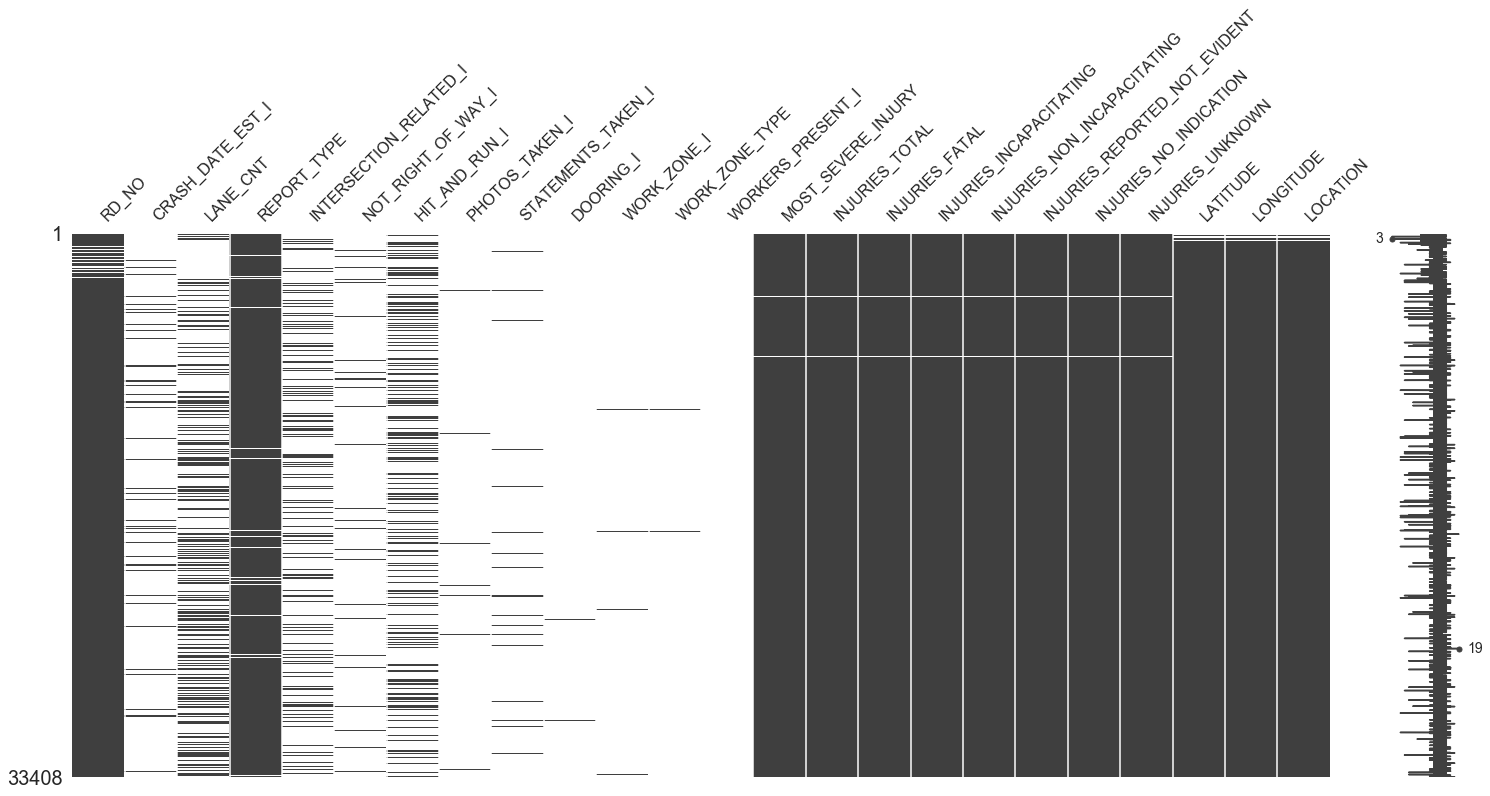

In [40]:
# List of columns that have any missing value
missingdata_crashes = crashes.columns[crashes.isnull().any()].tolist()
msno.matrix(crashes[missingdata_crashes])

**Missingness Pattern of `Vehicles`**

As 54 out of 72 features have missing values more than 50%, only remaining 18 features is visualized for the simplicity.

Seems the data are **missing at random (MAR)**, as missingness pattern is the same only within groups defined by the observed data, 

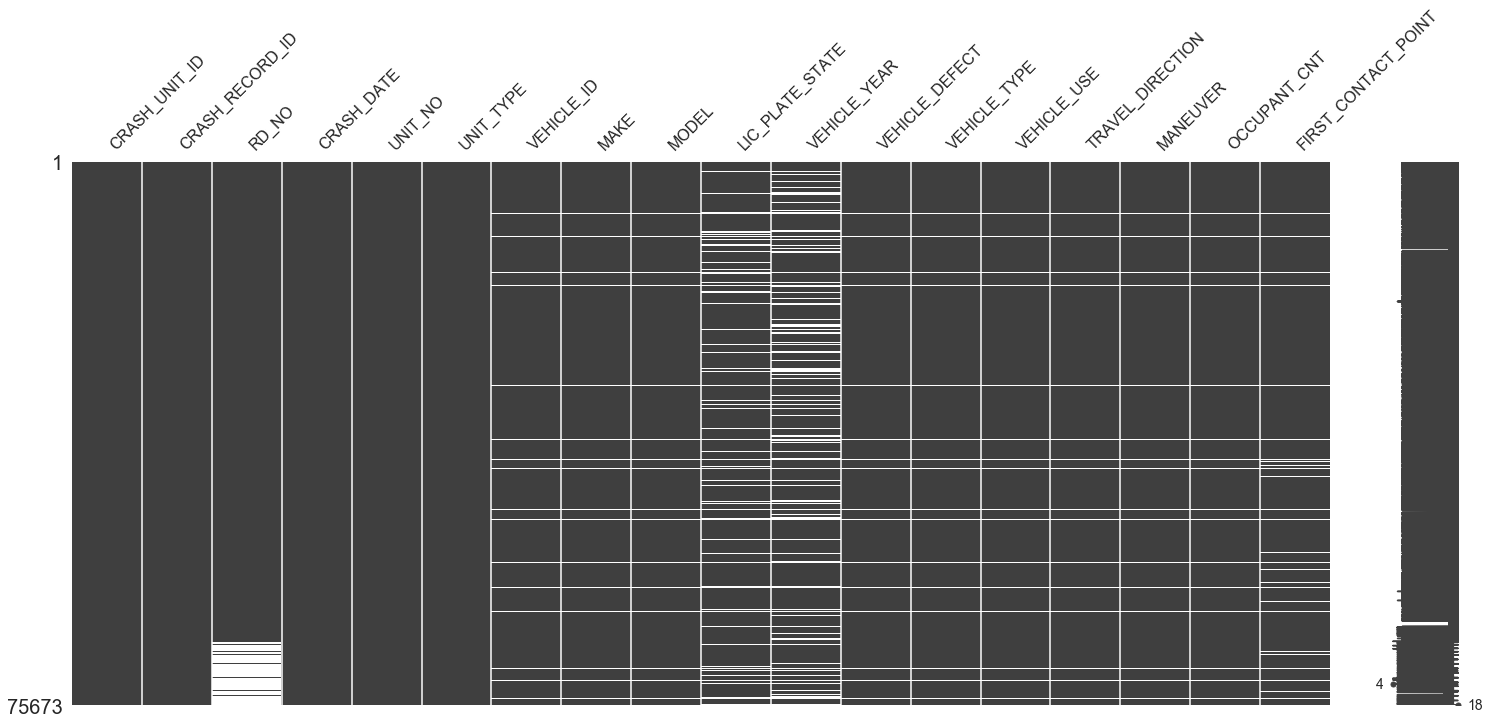

In [41]:
# List of columns that have any missing value
missingdata_vehicles = vehicles.columns[
    vehicles.isnull().mean().round(2) < 0.5].tolist()
msno.matrix(vehicles[missingdata_vehicles])

**Missingness Pattern of `People`**

Overall, both missingness pattern and correlation heatmap of People seem that features are **missing at random (MAR)**.

Sister features regarding city, driver, safety are missing together as expected  but cross features are not missing together. 

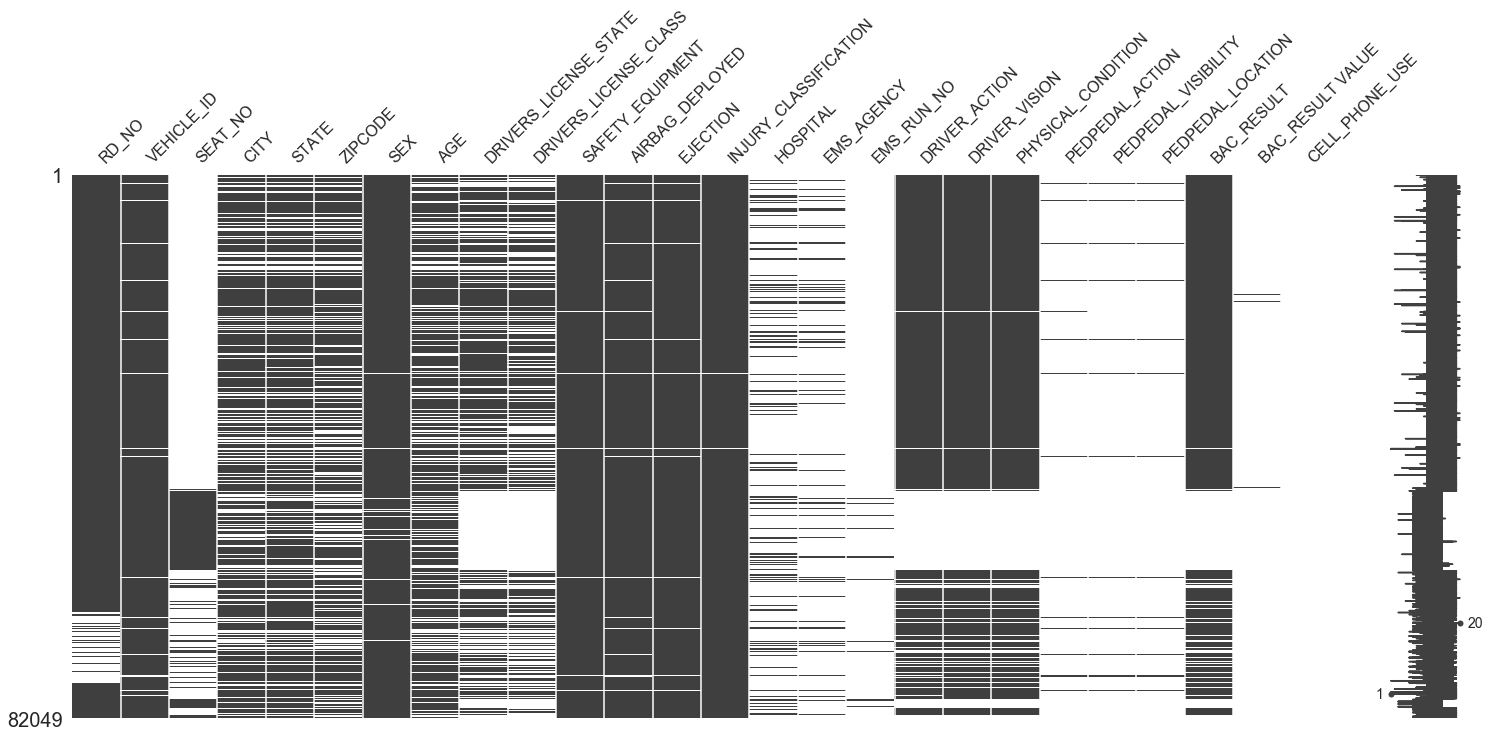

In [42]:
# List of columns that have any missing value
missingdata_people = people.columns[people.isnull().any()].tolist()
msno.matrix(people[missingdata_people])

**Correlation Heatmap of `Crashes`** 

Correlation between missing values of different columns.
This heatmap measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another and confirms above missing pattern of the dataset.


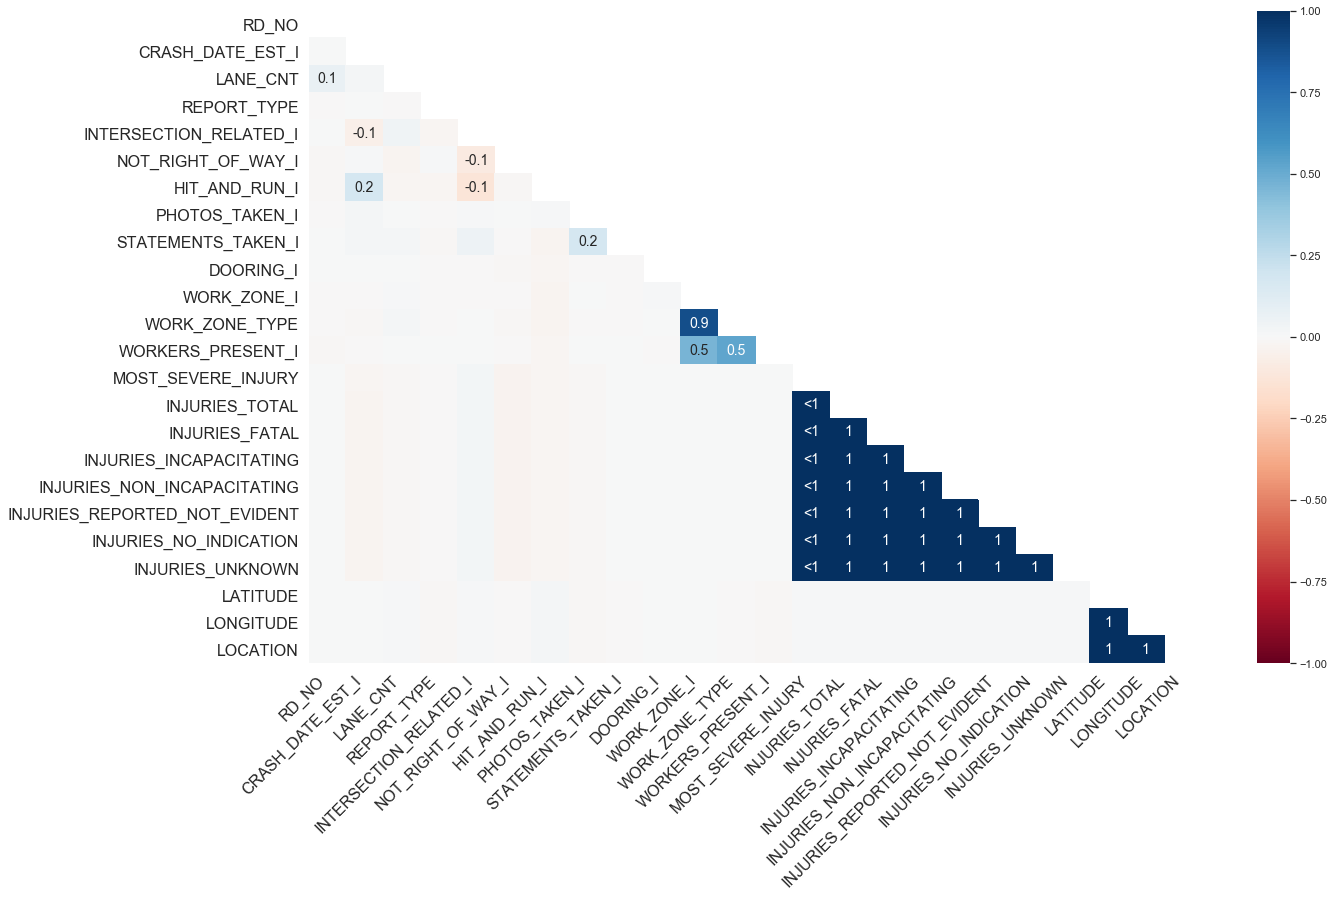

In [43]:
msno.heatmap(crashes)

**Correlation Heatmap of `People`**

Correlation between missing values in different columns

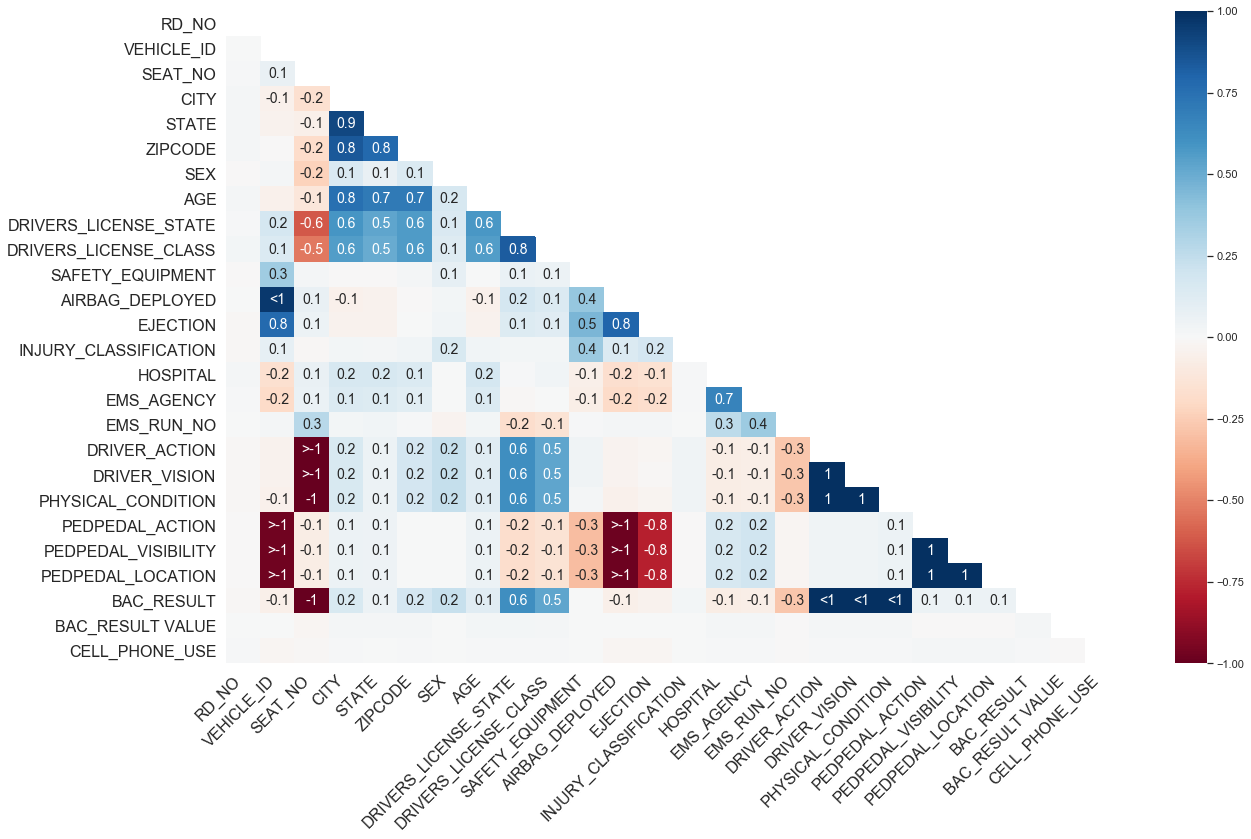

In [44]:
msno.heatmap(people)

<a id='data_distributions'></a>

## Overview of Data Distributions

*[Back to Top](#top)*

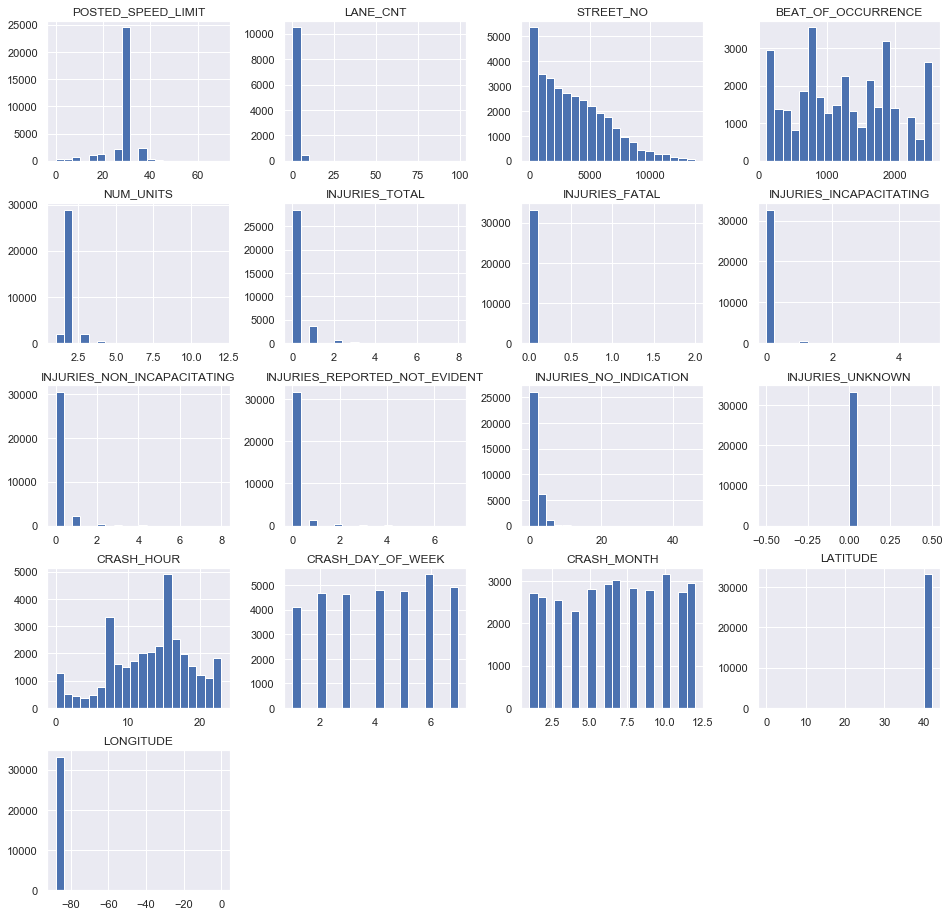

In [45]:
crashes.hist(bins=20, figsize=(16, 16))
plt.show()

### Summary Statistics

In [46]:
crashes.describe()

,POSTED_SPEED_LIMIT,LANE_CNT,STREET_NO,BEAT_OF_OCCURRENCE,NUM_UNITS,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE
count,33408.000000,10996.000000,33408.000000,33408.000000,33408.000000,33324.000000,33324.00000,33324.000000,33324.000000,33324.000000,33324.000000,33324.0,33408.000000,33408.000000,33408.000000,33215.000000,33215.000000
mean,28.420318,2.498272,3662.141134,1250.213332,2.037895,0.195205,0.00108,0.021936,0.109501,0.062688,2.030729,0.0,13.152029,4.122815,6.660500,41.856674,-87.674102
std,6.210942,1.669592,2847.516283,704.127405,0.471285,0.564194,0.03463,0.173489,0.420830,0.318674,1.220179,0.0,5.542940,1.980078,3.438983,0.335981,0.682890
min,0.000000,0.000000,1.000000,111.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,0.000000,-87.933994
25%,30.000000,2.000000,1240.000000,722.000000,2.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.0,9.000000,2.000000,4.000000,41.786257,-87.722139
50%,30.000000,2.000000,3199.000000,1214.000000,2.000000,0.000000,0.00000,0.000000,0.000000,0.000000,2.000000,0.0,14.000000,4.000000,7.000000,41.876677,-87.674754
75%,30.000000,4.000000,5518.000000,1822.000000,2.000000,0.000000,0.00000,0.000000,0.000000,0.000000,2.000000,0.0,17.000000,6.000000,10.000000,41.924907,-87.633925
max,70.000000,99.000000,13758.000000,2535.000000,12.000000,8.000000,2.00000,5.000000,8.000000,7.000000,46.000000,0.0,23.000000,7.000000,12.000000,42.022720,0.000000


In [47]:
#conditions = crashes[['TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION', 'LIGHTING_CONDITION']]
#sns.pairplot(conditions, height=2.5)

### Value Counts for Categorical Columns

#### `crashes`

- In most of crashes, there was no control device. 

In [48]:
for col in crashes.columns:
    if crashes[col].dtype.name == 'category':
        print('\033[1m', '\nColumn Name:', col, '\033[0m')
        print(crashes[col].value_counts())

 
Column Name: TRAFFIC_CONTROL_DEVICE 
NO CONTROLS                 19052
TRAFFIC SIGNAL               9318
STOP SIGN/FLASHER            3480
UNKNOWN                      1020
OTHER                         217
LANE USE MARKING               91
YIELD                          61
OTHER REG. SIGN                48
OTHER WARNING SIGN             28
POLICE/FLAGMAN                 20
RAILROAD CROSSING GATE         17
PEDESTRIAN CROSSING SIGN       12
SCHOOL ZONE                    12
OTHER RAILROAD CROSSING        11
FLASHING CONTROL SIGNAL         9
DELINEATORS                     8
NO PASSING                      2
RR CROSSING SIGN                1
BICYCLE CROSSING SIGN           1
Name: TRAFFIC_CONTROL_DEVICE, dtype: int64
 
Column Name: DEVICE_CONDITION 
NO CONTROLS                 19287
FUNCTIONING PROPERLY        11775
UNKNOWN                      1780
OTHER                         267
FUNCTIONING IMPROPERLY        170
NOT FUNCTIONING               113
WORN REFLECTIVE MATERIAL       11
M

In [49]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

Categorical Columns correlation of crashes data


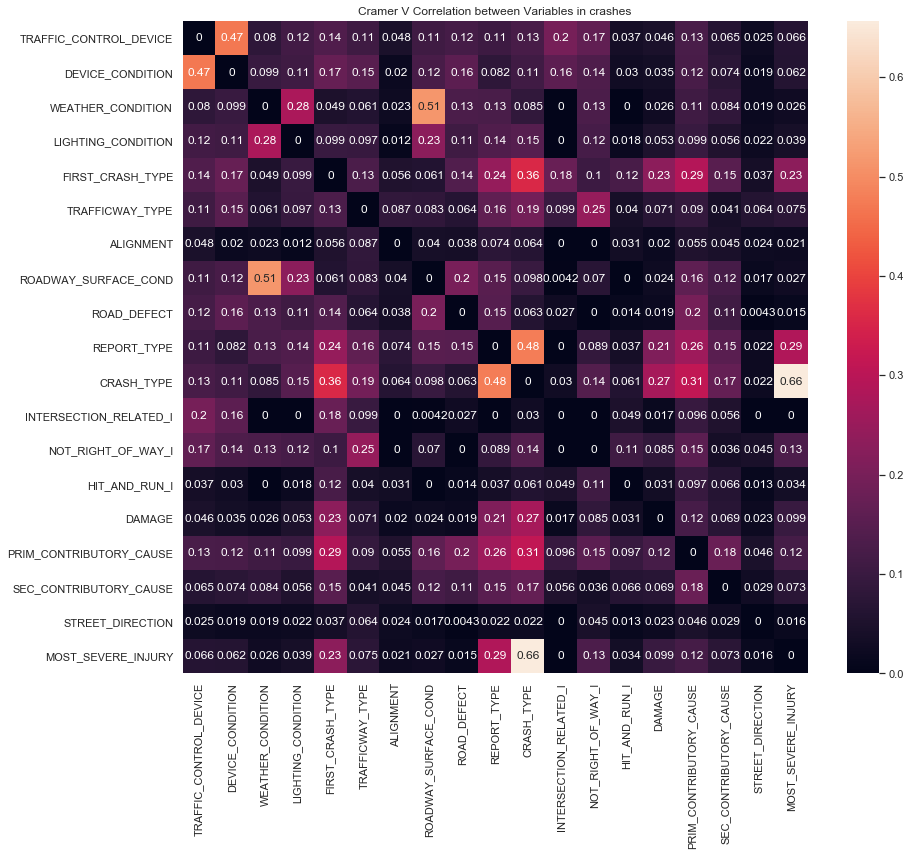

In [50]:
# Categorical Columns of crashes data
print("Categorical Columns correlation of crashes data")

cols = ["TRAFFIC_CONTROL_DEVICE", "DEVICE_CONDITION", "WEATHER_CONDITION", "LIGHTING_CONDITION", "FIRST_CRASH_TYPE", "TRAFFICWAY_TYPE", "ALIGNMENT", "ROADWAY_SURFACE_COND", "ROAD_DEFECT", "REPORT_TYPE", "CRASH_TYPE", "INTERSECTION_RELATED_I", "NOT_RIGHT_OF_WAY_I", "HIT_AND_RUN_I", "DAMAGE", "PRIM_CONTRIBUTORY_CAUSE", "SEC_CONTRIBUTORY_CAUSE", "STREET_DIRECTION", "MOST_SEVERE_INJURY"]
corrM = np.zeros((len(cols),len(cols)))

for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(crashes[col1], crashes[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(14, 12))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("Cramer V Correlation between Variables in crashes");

#### `vehicles`

In [51]:
for col in vehicles.columns:
    if vehicles[col].dtype.name == 'category':
        print('\033[1m', '\nColumn Name:', col, '\033[0m')
        print(vehicles[col].value_counts())

 
Column Name: UNIT_TYPE 
DRIVER                 63122
PARKED                  9995
PEDESTRIAN              1025
DRIVERLESS               719
BICYCLE                  593
NON-MOTOR VEHICLE         79
NON-CONTACT VEHICLE       16
DISABLED VEHICLE           9
EQUESTRIAN                 3
Name: UNIT_TYPE, dtype: int64
 
Column Name: MAKE 
CHEVROLET                             8580
FORD                                  7442
UNKNOWN                               7083
TOYOTA MOTOR COMPANY, LTD.            6401
NISSAN                                6313
                                      ... 
KWICK KIT CEMENT MIXER                   1
KUT-KWICK CORP. BRUNSWICK, GEORGIA       1
KON KWEST MANUFACTURING                  1
KING TRAILER CO., INC.                   1
"(ASSEMBLED FROM PARTS, HOMEMADE)"       1
Name: MAKE, Length: 326, dtype: int64
 
Column Name: MODEL 
UNKNOWN                                       12919
OTHER (EXPLAIN IN NARRATIVE)                   2772
CAMRY                    

Categorical Columns correlation of vehicles data


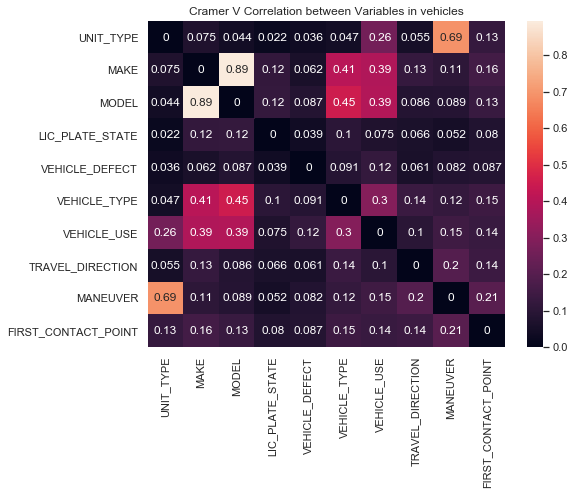

In [52]:
# Categorical Columns of vehicles data
print("Categorical Columns correlation of vehicles data")

cols = ["UNIT_TYPE", "MAKE", "MODEL", "LIC_PLATE_STATE", "VEHICLE_DEFECT", "VEHICLE_TYPE", "VEHICLE_USE", "TRAVEL_DIRECTION", "MANEUVER", "FIRST_CONTACT_POINT"]
corrM = np.zeros((len(cols),len(cols)))

for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(vehicles[col1], vehicles[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("Cramer V Correlation between Variables in vehicles");

#### `people`

In [53]:
for col in people.columns:
    if people[col].dtype.name == 'category':
        print('\033[1m', '\nColumn Name:', col, '\033[0m')
        print(people[col].value_counts())

 
Column Name: CITY 
CHICAGO             43142
CICERO                620
SKOKIE                382
BERWYN                340
UNKNOWN               322
                    ...  
MERRELVILLE             1
MERRILLVLLE             1
MERRIONEYYE PARK        1
MERRIT ISLAND           1
60630                   1
Name: CITY, Length: 2099, dtype: int64
 
Column Name: STATE 
IL    58365
IN      952
XX      442
WI      271
MI      214
FL      145
TX      122
OH      114
CA       97
MO       84
IA       83
MN       81
GA       70
NY       65
TN       47
AZ       47
WA       43
CO       38
NC       37
PA       31
MS       30
VA       29
KS       27
MA       26
AR       25
KY       24
AL       23
MD       23
LA       23
NJ       21
OK       20
NB       19
NV       17
SC       14
ID       12
NH        9
ND        8
OR        7
UT        6
CT        6
SD        5
WV        4
WY        4
RI        3
DE        3
DC        3
NM        3
VT        2
AK        2
ME        1
HI        1
MT        1
Name: ST

Categorical Columns correlation of people data


<ipython-input-49-50c89b9f47f1>:13: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))


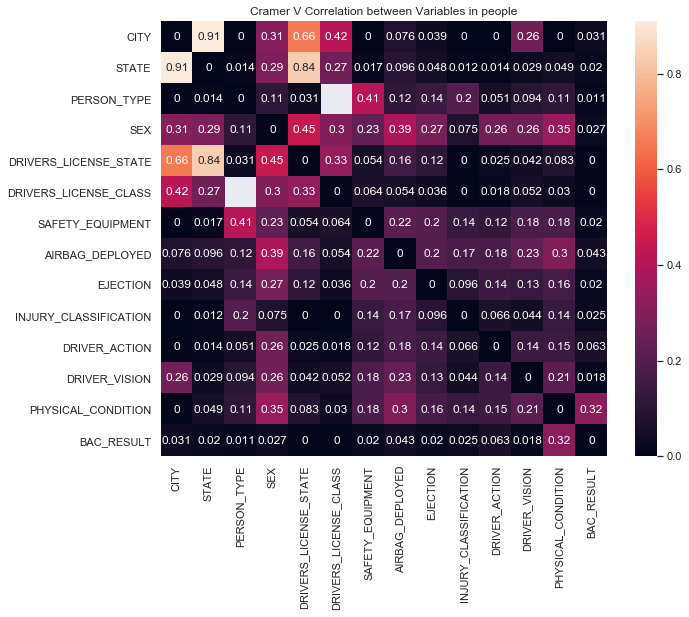

In [54]:
# Categorical Columns of people data
print("Categorical Columns correlation of people data")

cols = ["CITY", "STATE", "PERSON_TYPE", "SEX", "DRIVERS_LICENSE_STATE", "DRIVERS_LICENSE_CLASS", "SAFETY_EQUIPMENT", "AIRBAG_DEPLOYED", "EJECTION", "INJURY_CLASSIFICATION", "DRIVER_ACTION", "DRIVER_VISION", "PHYSICAL_CONDITION", "BAC_RESULT"]
corrM = np.zeros((len(cols),len(cols)))

for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(people[col1], people[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("Cramer V Correlation between Variables in people");

In [55]:
#crashes['CRASH_TYPE'].value_counts().plot(kind='bar')
#sns.displot(crashes)

The target feature that we want to forecast, as the further analysis will be performed in its context.

In [56]:
#road_defect_count = crashes['ROAD_DEFECT'].value_counts()
#sns.set(style="darkgrid")
#sns.barplot(road_defect_count.index, road_defect_count.values, alpha=0.9)

<a id='data_different'></a>

## Analysis of Geolocation, Time Series and Categorical Data

*[Back to Top](#top)*

### Analysis of Geographical Data

In [57]:
#y = df['rando']
#removed_outliers = y.between(y.quantile(.05), y.quantile(.95))

#crashes.plot(kind='scatter', x='LONGITUDE', y='LATITUDE',
#             xticks=np.arange(min(crashes['LONGITUDE']), max(crashes['LONGITUDE'])+1, 10),
#             yticks=np.arange(min(crashes['LATITUDE']), max(crashes['LATITUDE'])+1, 1),
#             figsize = (10, 12), alpha = 0.4, s=1, colorbar = False, #sharex = False,
#             c = crashes['INJURIES_TOTAL'], cmap=plt.get_cmap('Set1'))

### Analysis of Time Data

In [58]:
# on Crashes
crashes_ts = crashes.copy()
# Convert Crash_data into time
crashes_ts['CRASH_DATE'] = pd.to_datetime(crashes_ts.CRASH_DATE)
# Creating three new columns for easy querying
crashes_ts['YEAR'] = crashes_ts.CRASH_DATE.dt.year
crashes_ts['MONTH'] = crashes_ts.CRASH_DATE.dt.month
crashes_ts['DAY'] = crashes_ts.CRASH_DATE.dt.day
# Function to compare considered feature with time

def time_pivot(data, x):
    tdf = data[['YEAR', x]].groupby(['YEAR', x]).size().rename('Count').reset_index()
    return pd.pivot_table(tdf, columns = 'YEAR', index = x)

In [59]:
# Year vs. Crash Type => Mostly No injury/drive away

time_pivot(crashes_ts, "CRASH_TYPE").sort_values(by = ('Count', 2017), ascending = False)

Count                  
YEAR                              2017  2018  2019  2020
CRASH_TYPE                                              
NO INJURY / DRIVE AWAY            2074  8713  8446  4834
INJURY AND / OR TOW DUE TO CRASH   782  3239  3151  2169

In [60]:
# Year vs Damages. => Most of our data are at between 2018-2019

time_pivot(crashes_ts, 'DAMAGE').sort_values(by = ('Count', 2017), ascending = False)

Count                  
YEAR           2017  2018  2019  2020
DAMAGE                               
OVER $1,500    1633  6926  6724  4328
$501 - $1,500   851  3418  3302  1929
$500 OR LESS    372  1608  1571   746

Rush Hours appear to have more crashes

[Text(0, 0.5, 'Number of Crashes'),
 Text(0.5, 0, 'Day Hours'),
 Text(0.5, 1.0, 'Total Number of Crashes by Damage Categories in Each Hour')]

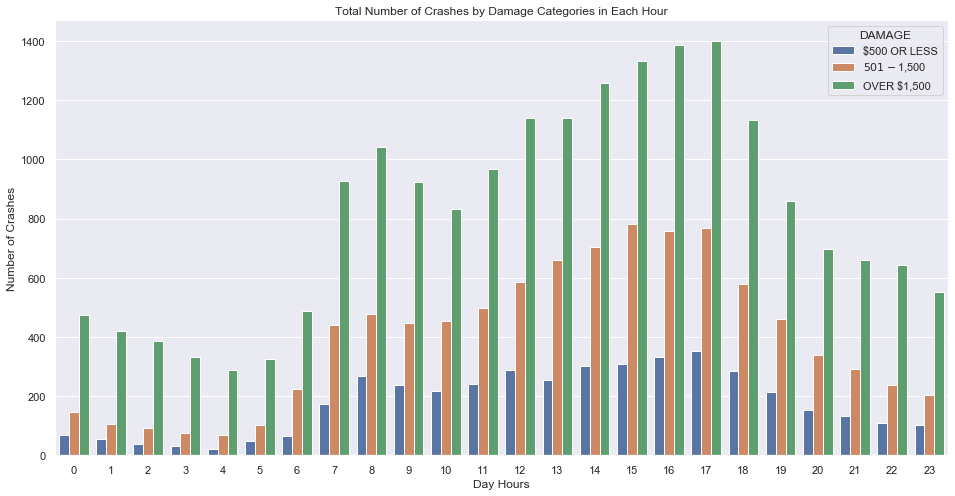

In [61]:
sns.set(rc={'figure.figsize':(16,8)})
ax=sns.countplot(x='CRASH_HOUR', hue='DAMAGE', data=crashes)
ax.set(xlabel="Day Hours", ylabel = "Number of Crashes", 
       title = 'Total Number of Crashes by Damage Categories in Each Hour')

No significant difference in total number of crashes between days.

[Text(0, 0, 'Sunday'),
 Text(0, 0, 'Monday'),
 Text(0, 0, 'Tuesday'),
 Text(0, 0, 'Wednesday'),
 Text(0, 0, 'Thursday'),
 Text(0, 0, 'Friday'),
 Text(0, 0, 'Saturday')]

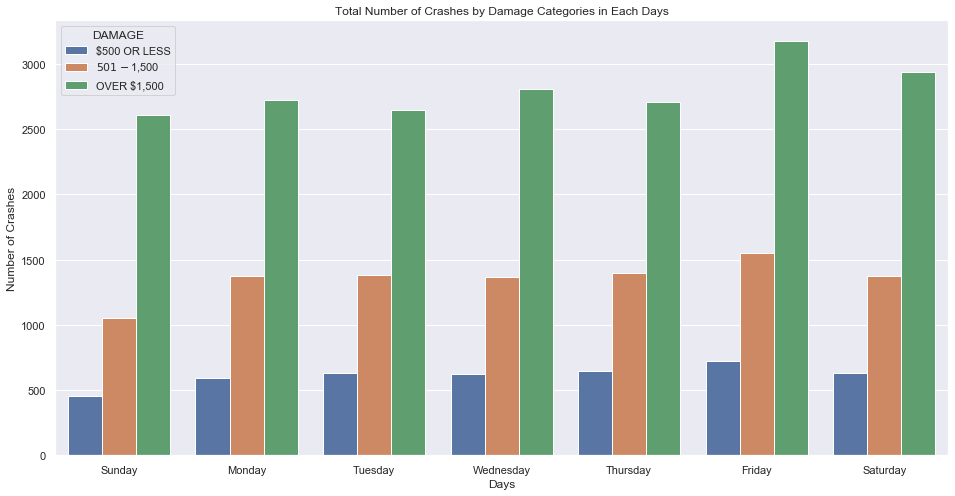

In [62]:
sns.set(rc={'figure.figsize':(16,8)})
ax=sns.countplot(x='CRASH_DAY_OF_WEEK', hue='DAMAGE', data=crashes)
ax.set(xlabel = 'Days', title = 'Total Number of Crashes by Damage Categories in Each Days',
       ylabel = "Number of Crashes")
ax.set_xticklabels(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])

### Analysis of Categorical Data

[Text(0, 0.5, 'Total Number of Injuries'),
 Text(0.5, 0, 'Posted Speed Limit'),
 Text(0.5, 1.0, '2')]

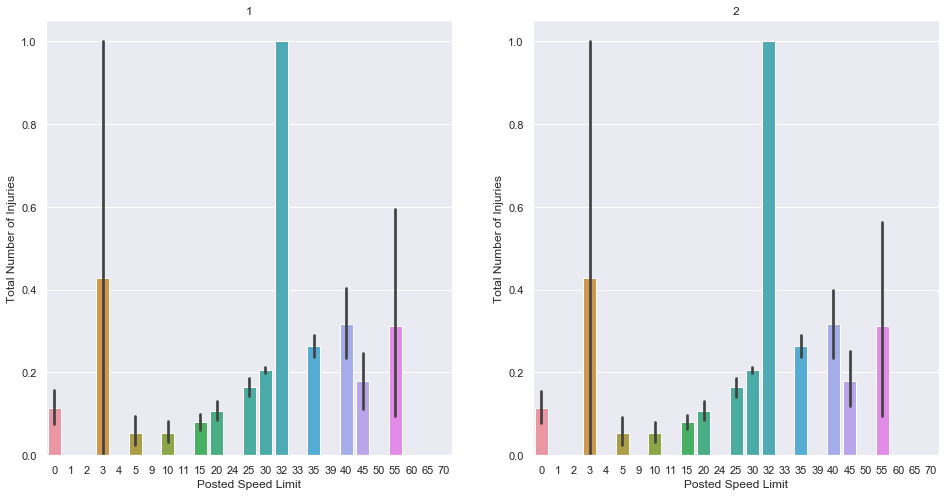

In [63]:
# Total injuries by posted speed limits
fig, axs = plt.subplots(ncols=2)
sns.set(rc={'figure.figsize':(20,10)})

ax_1=sns.barplot(x='POSTED_SPEED_LIMIT', y='INJURIES_TOTAL', data=crashes, ax=axs[0])
ax_1.set(xlabel="Posted Speed Limit", ylabel = "Total Number of Injuries", title = '1')

ax_2=sns.barplot(x='POSTED_SPEED_LIMIT', y='INJURIES_TOTAL', data=crashes, ax=axs[1])
ax_2.set(xlabel="Posted Speed Limit", ylabel = "Total Number of Injuries", title = '2')

#ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

(array([0, 1, 2]), <a list of 3 Text yticklabel objects>)

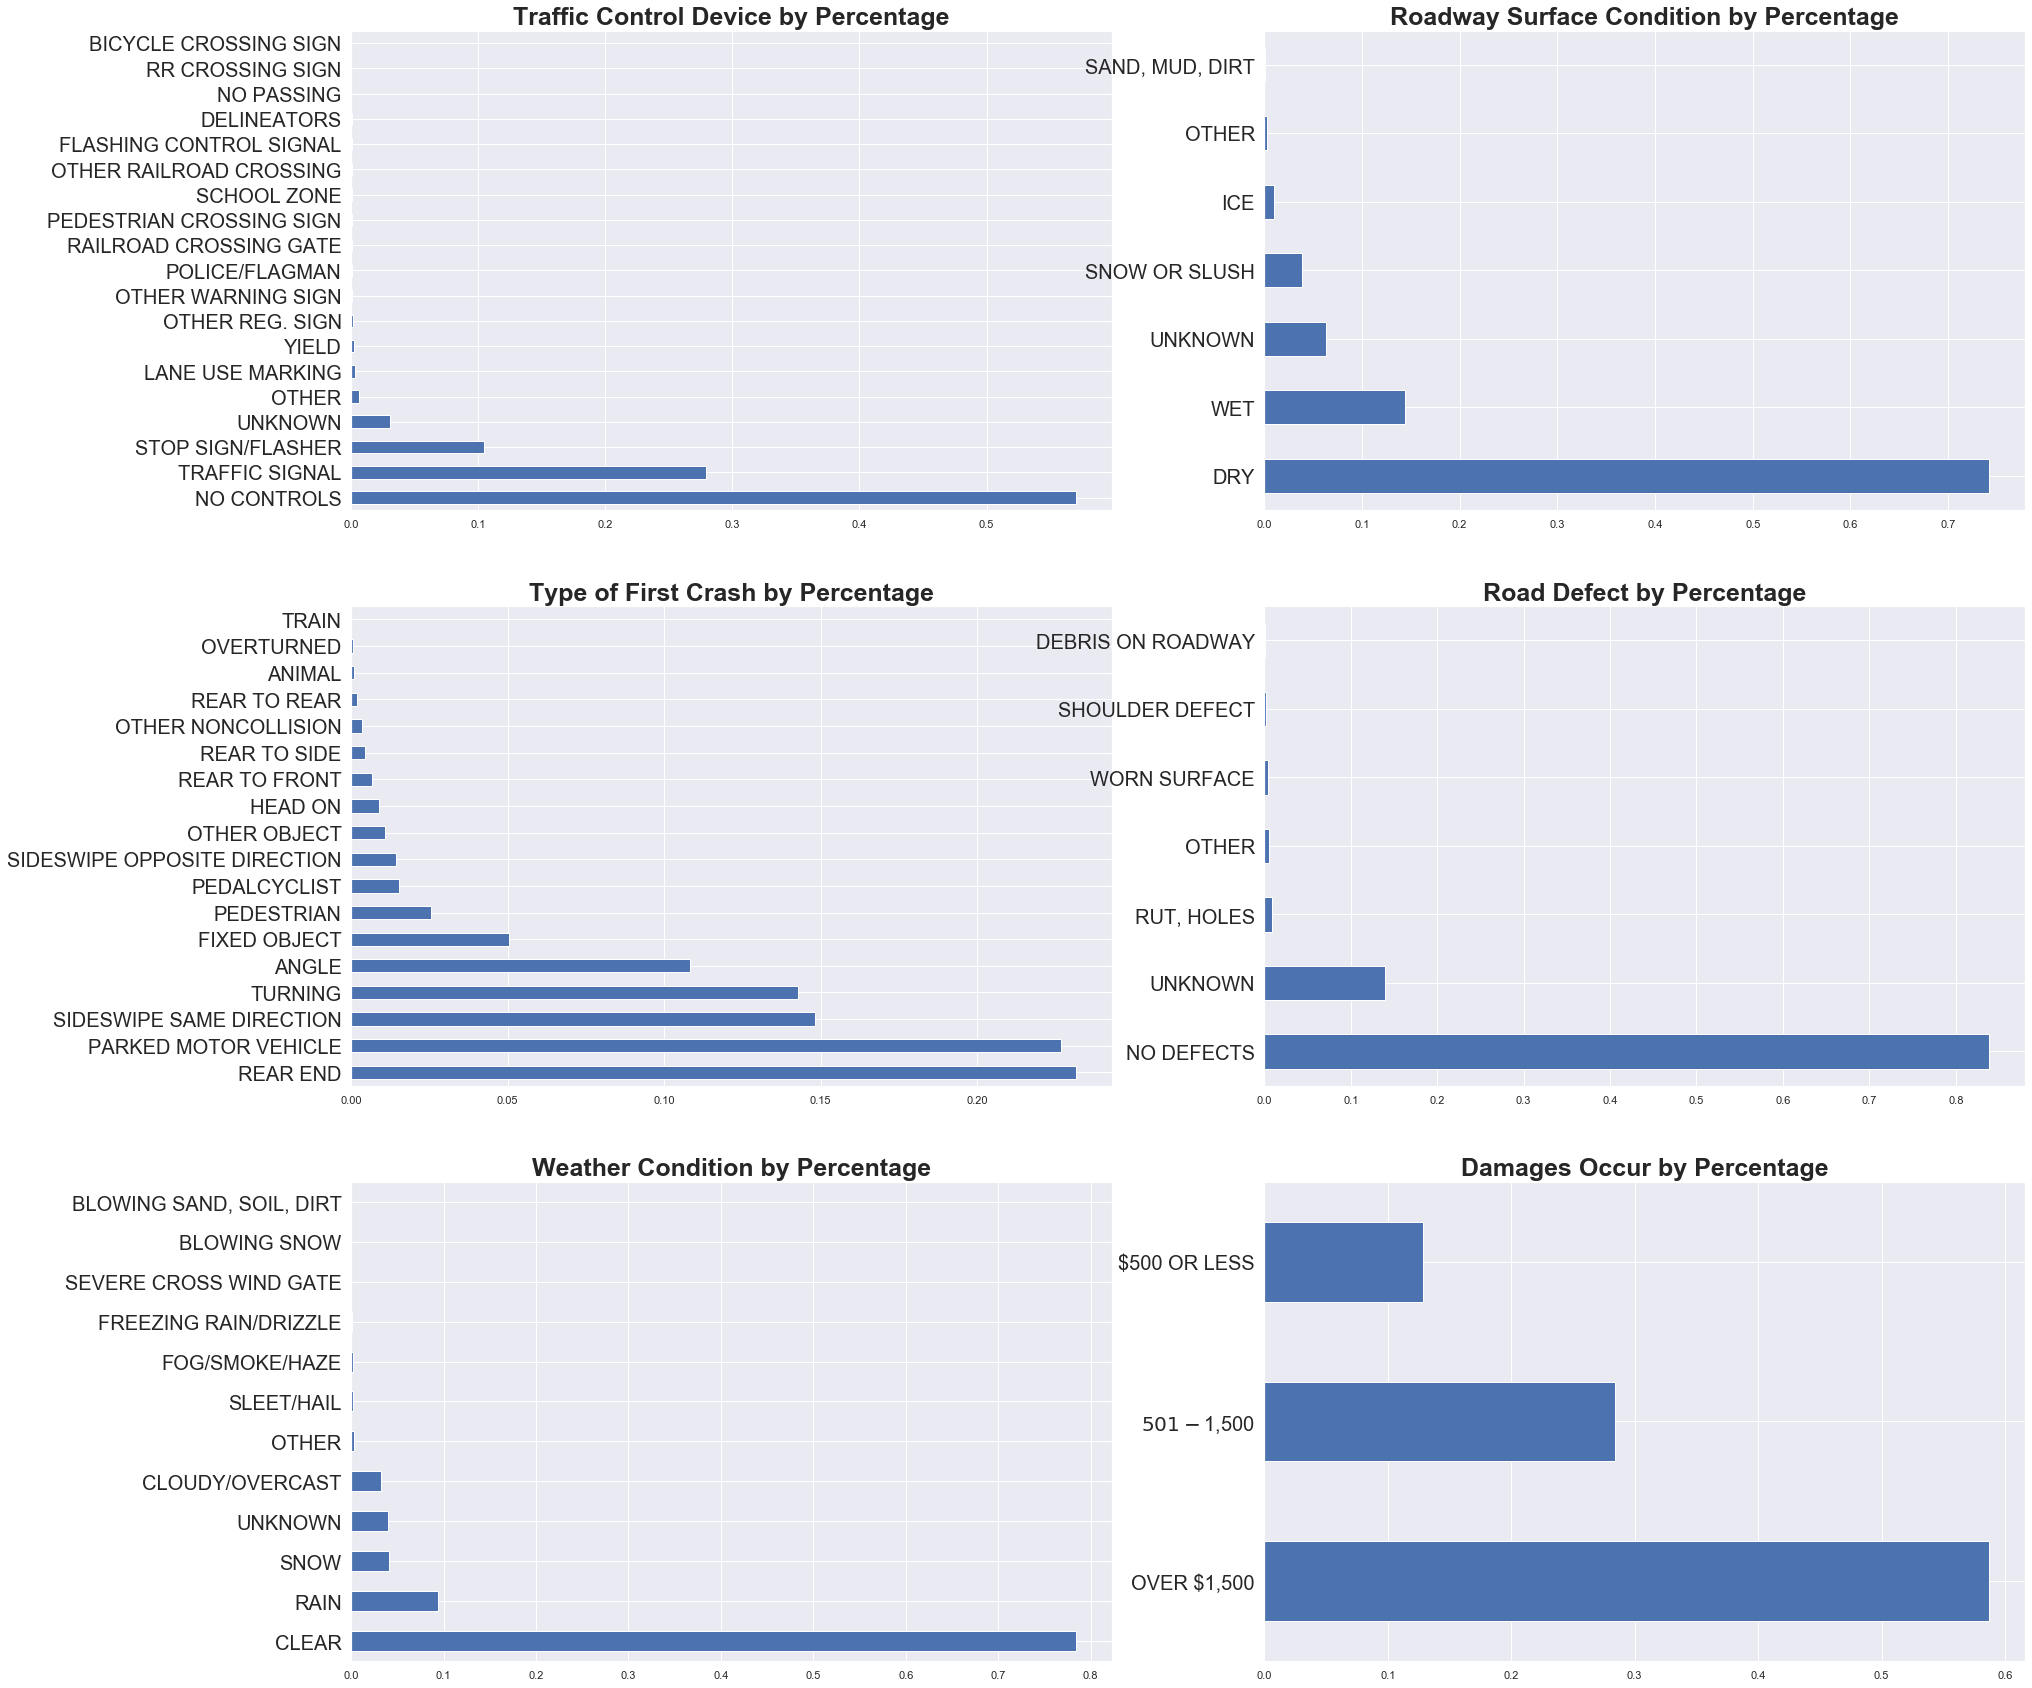

In [64]:
plt.figure(figsize=(30, 30))

# Traffic Control
plt.subplot(3, 2, 1)
crashes.TRAFFIC_CONTROL_DEVICE.value_counts(normalize = True).plot.barh()
plt.title("Traffic Control Device by Percentage", fontsize=25, fontweight="bold")
plt.yticks(fontsize=20)

# Road Condition
plt.subplot(3, 2, 2)
crashes.ROADWAY_SURFACE_COND.value_counts(normalize = True).plot.barh()
plt.title("Roadway Surface Condition by Percentage", fontsize=25, fontweight="bold")
plt.yticks(fontsize=20)

# Crash Type
plt.subplot(3, 2, 3)
crashes.FIRST_CRASH_TYPE.value_counts(normalize = True).plot.barh()
plt.title("Type of First Crash by Percentage", fontsize=25, fontweight="bold")
plt.yticks(fontsize=20)

#Road Defect
plt.subplot(3, 2, 4)
crashes.ROAD_DEFECT.value_counts(normalize = True).plot.barh()
plt.title("Road Defect by Percentage", fontsize=25, fontweight="bold")
plt.yticks(fontsize=20)

# Weather Condition
plt.subplot(3, 2, 5)
crashes.WEATHER_CONDITION.value_counts(normalize = True).plot.barh()
plt.title("Weather Condition by Percentage", fontsize=25, fontweight="bold")
plt.yticks(fontsize=20)

# Damage from crashes
plt.subplot(3, 2, 6)
crashes.DAMAGE.value_counts(normalize = True).plot.barh()
plt.title("Damages Occur by Percentage", fontsize=25, fontweight="bold")
plt.yticks(fontsize=20)

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45]),
 <a list of 10 Text xticklabel objects>)

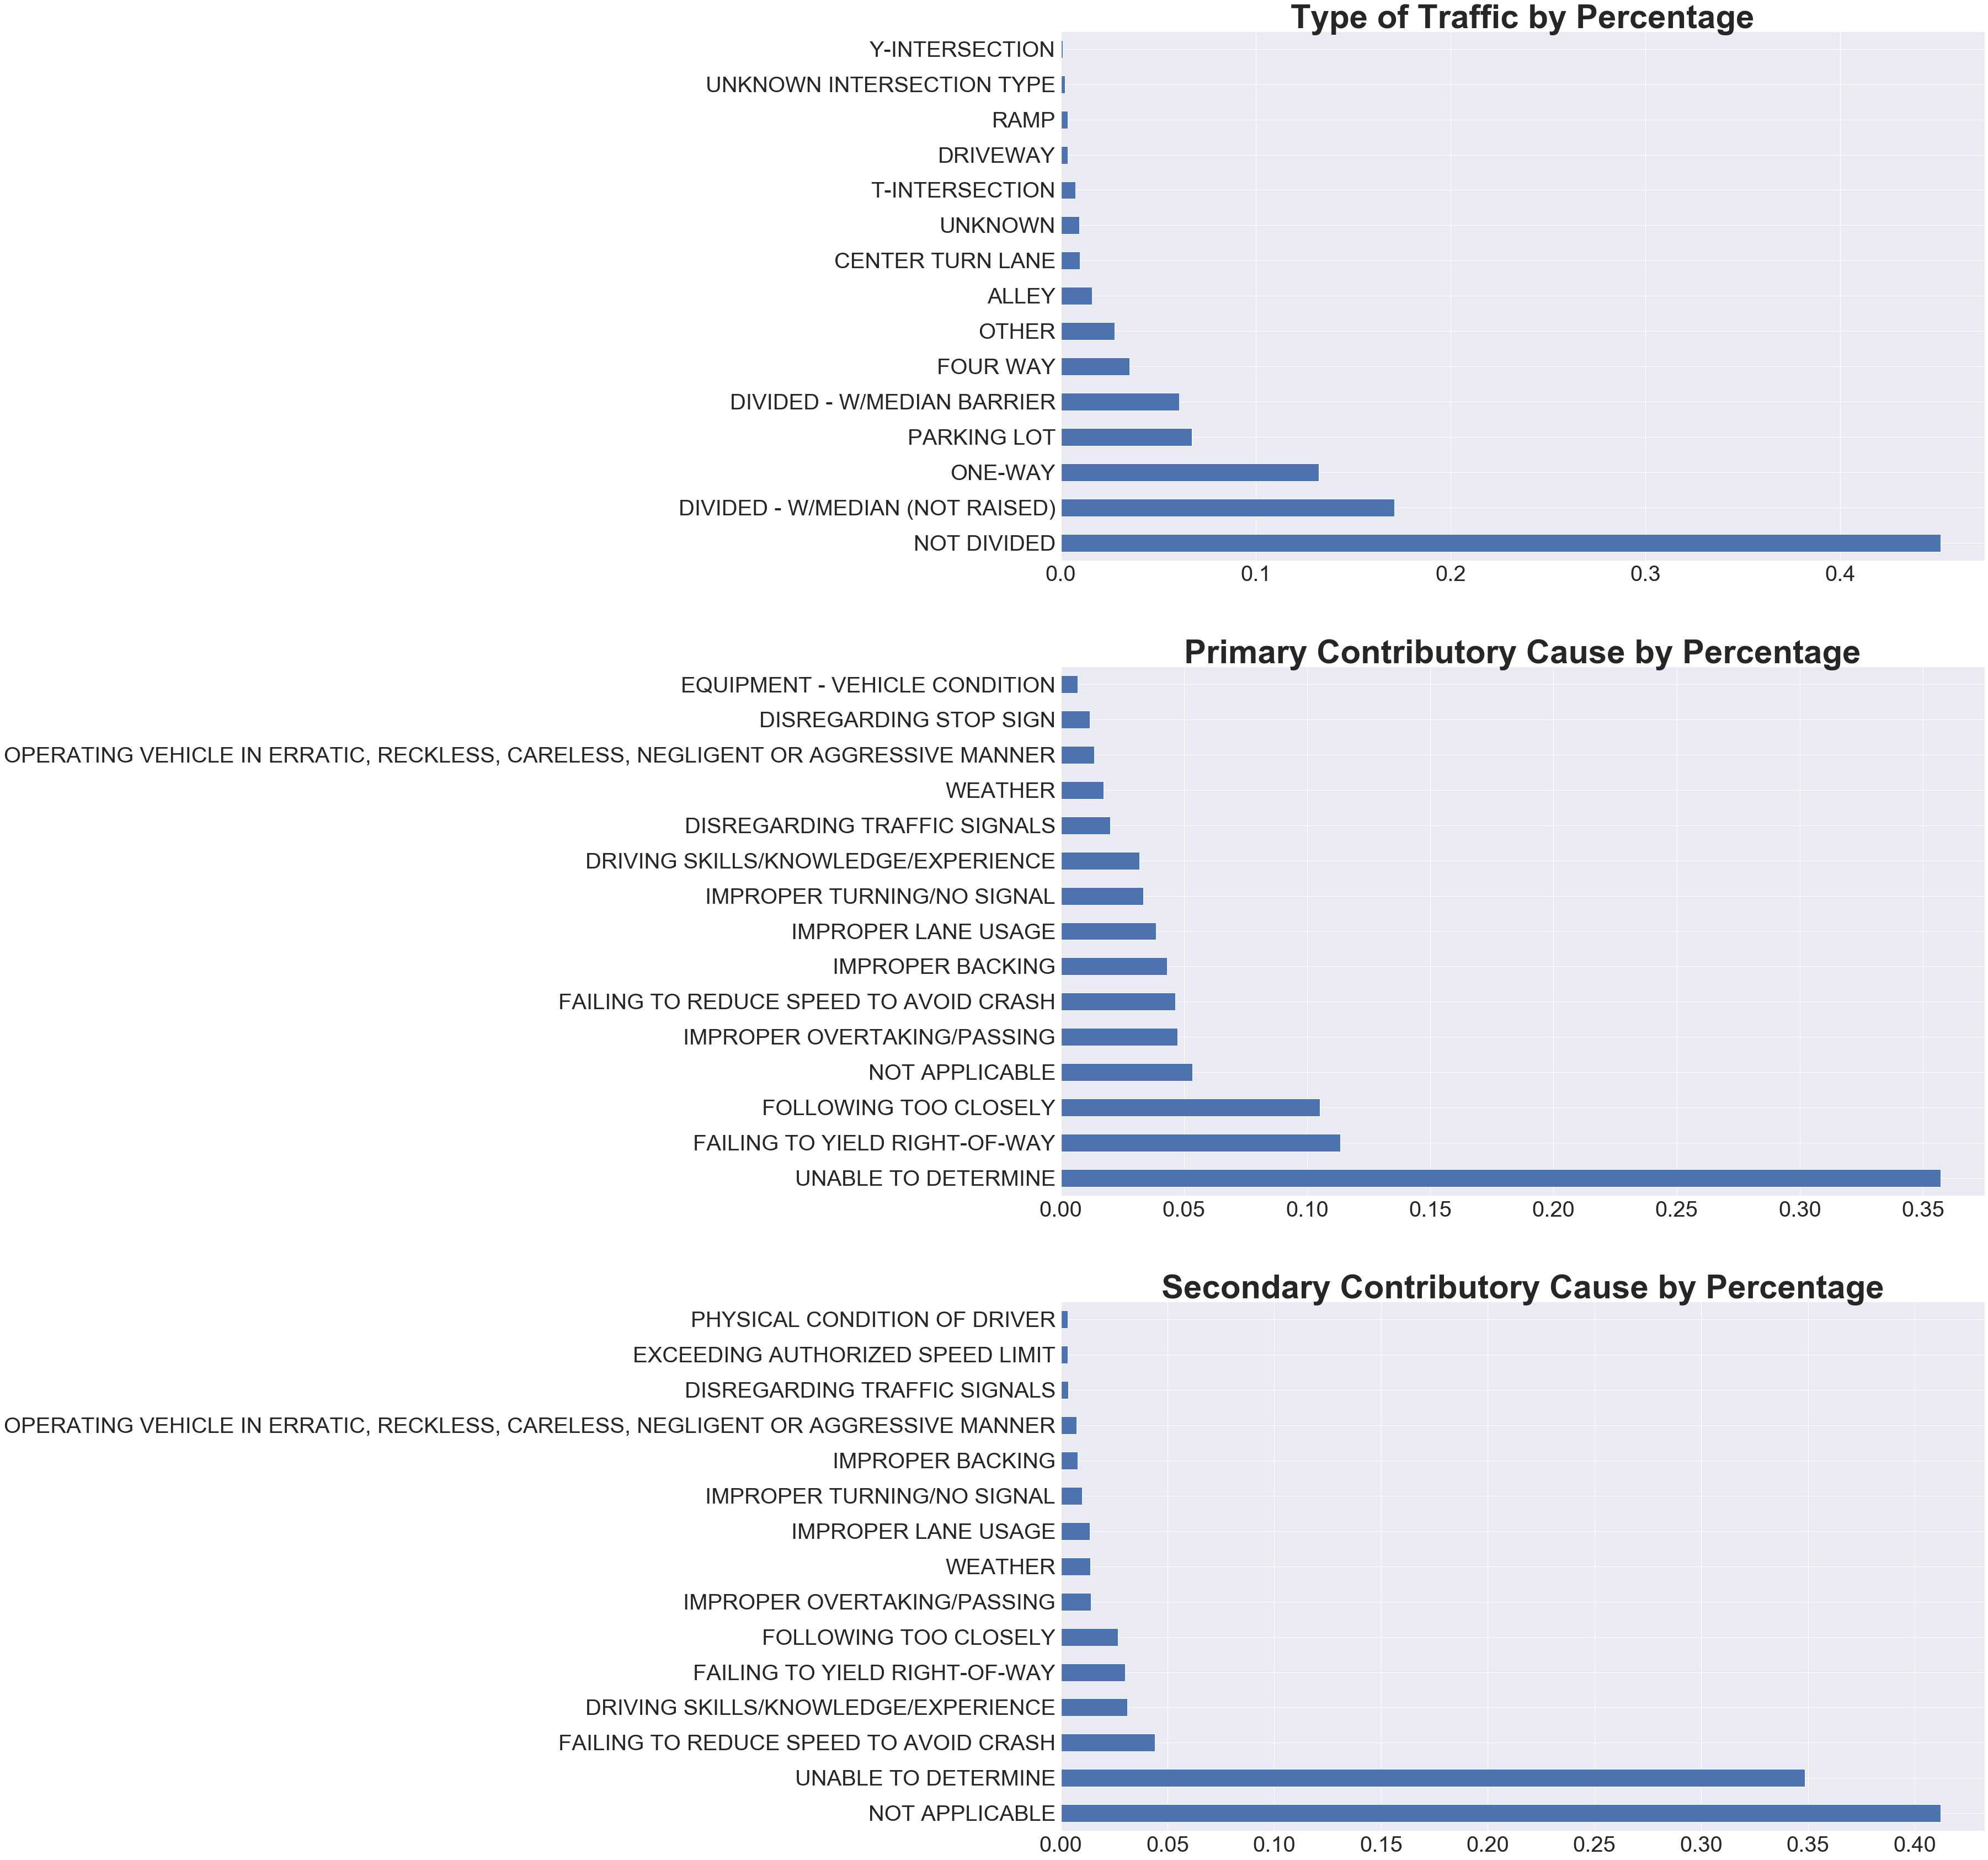

In [65]:
plt.figure(figsize=(30, 60))

# Type of Traffic
plt.subplot(3, 1, 1)
crashes.TRAFFICWAY_TYPE.value_counts(normalize=True)[:15].plot.barh()
plt.title('Type of Traffic by Percentage', fontsize=60, fontweight="bold")
plt.yticks(fontsize=40)
plt.xticks(fontsize=40)

# Primary Contributory Cause
plt.subplot(3, 1, 2)
crashes.PRIM_CONTRIBUTORY_CAUSE.value_counts(normalize = True)[:15].plot.barh()
plt.title("Primary Contributory Cause by Percentage", fontsize=60, fontweight="bold")
plt.yticks(fontsize=40)
plt.xticks(fontsize=40)

# Secondary Contributory Cause
plt.subplot(3, 1, 3)
crashes.SEC_CONTRIBUTORY_CAUSE.value_counts(normalize = True)[:15].plot.barh()
plt.title("Secondary Contributory Cause by Percentage", fontsize=60, fontweight="bold")
plt.yticks(fontsize=40)
plt.xticks(fontsize=40)

<a id='data_correlation'></a>

## Correlation Analysis

*[Back to Top](#top)*

Potential target features are
- `crashes.DAMAGE`
- `crashes.INJURIES_TOTAL`
- `crashes.INJURIES_FATAL`
- `people.INJURY_CLASSIFICATION`

---

Potential awareness features are
- `crashes.PRIM_CONTRIBUTORY_CAUSE`
- `crashes.SEC_CONTRIBUTORY_CAUSE`
- `people.DRIVER_ACTION`
- `people.DRIVER_LICENSE_CLASS`
- `people.PHYSICAL_CONDITION`

---

Potential insight features are
- `crashes.POSTED_SPEED_LIMIT`
- `crashes.CRASH_TYPE`
- `crashes.STREET_NAME`
- `vehicles.UNIT_TYPE`
- `vehicles.VEHICLE_TYPE`
- `vehicles.VEHICLE_DEFECT`
- `vehicles.MANEUVER`

### Hypothesis Testing 

Let's test a few hypothesis about the relations between above features in the dataset.

**H0, the null hypothesis** is always a hypothesis of **no change** to check whether we have enough evidence to reject it.

To check and identify any possible association/correlation statistically, 
- **Pearson Correlation Coefficient** will be used between two **continuous** variables. 
- **Chi-Squared Test** will be used between two **categorical** variables.

#### Feature 1

**H0: The usage of safety equipment has no impact on the probability of the type of injuries.**

The first hypothesis to test would be whether or not the probability of any type of injury to occur depends on the usage of safety equipment.

In [66]:
table1, results1 = rp.crosstab(people['SAFETY_EQUIPMENT'], people['INJURY_CLASSIFICATION'], 
                             prop='col', test='chi-square')
    
table1

INJURY_CLASSIFICATION  \
INJURY_CLASSIFICATION                                      FATAL   
SAFETY_EQUIPMENT                                                   
BICYCLE HELMET (PEDACYCLIST INVOLVED ONLY)                  0.00   
BOOSTER SEAT                                                0.00   
CHILD RESTRAINT - FORWARD FACING                            0.00   
CHILD RESTRAINT - REAR FACING                               0.00   
CHILD RESTRAINT - TYPE UNKNOWN                              0.00   
CHILD RESTRAINT NOT USED                                    0.00   
CHILD RESTRAINT USED                                        0.00   
CHILD RESTRAINT USED IMPROPERLY                             0.00   
DOT COMPLIANT MOTORCYCLE HELMET                             2.56   
HELMET NOT USED                                             5.13   
HELMET USED                                                 0.00   
NONE PRESENT                                               20.51   
NOT DOT COMPLIANT MOTORCYCLE HELMET                         0.00   
SAFETY BELT NOT USED                                       10.26   
SAFETY BELT USED                                            7.69   
SHOULD/LAP BELT USED IMPROPERLY                             0.00   
STRETCHER                                                   0.00   
USAGE UNKNOWN                                              53.85   
WHEELCHAIR                                                  0.00   
All                                                       100.00   

                                                                  \
INJURY_CLASSIFICATION                      INCAPACITATING INJURY   
SAFETY_EQUIPMENT                                                   
BICYCLE HELMET (PEDACYCLIST INVOLVED ONLY)                  1.51   
BOOSTER SEAT                                                0.00   
CHILD RESTRAINT - FORWARD FACING                            0.13   
CHILD RESTRAINT - REAR FACING                               0.00   
CHILD RESTRAINT - TYPE UNKNOWN                              0.25   
CHILD RESTRAINT NOT USED                                    0.00   
CHILD RESTRAINT USED                                        0.13   
CHILD RESTRAINT USED IMPROPERLY                             0.00   
DOT COMPLIANT MOTORCYCLE HELMET                             1.89   
HELMET NOT USED                                             6.18   
HELMET USED                                                 0.88   
NONE PRESENT                                               17.28   
NOT DOT COMPLIANT MOTORCYCLE HELMET                         0.25   
SAFETY BELT NOT USED                                        1.89   
SAFETY BELT USED                                           34.80   
SHOULD/LAP BELT USED IMPROPERLY                             0.00   
STRETCHER                                                   0.00   
USAGE UNKNOWN                                              34.55   
WHEELCHAIR                                                  0.25   
All                                                       100.00   

                                                                    \
INJURY_CLASSIFICATION                      NO INDICATION OF INJURY   
SAFETY_EQUIPMENT                                                     
BICYCLE HELMET (PEDACYCLIST INVOLVED ONLY)                    0.05   
BOOSTER SEAT                                                  0.04   
CHILD RESTRAINT - FORWARD FACING                              0.25   
CHILD RESTRAINT - REAR FACING                                 0.10   
CHILD RESTRAINT - TYPE UNKNOWN                                0.10   
CHILD RESTRAINT NOT USED                                      0.05   
CHILD RESTRAINT USED                                          0.65   
CHILD RESTRAINT USED IMPROPERLY                               0.01   
DOT COMPLIANT MOTORCYCLE HELMET                               0.03   
HELMET NOT USED                                               0.14   
HEL

The result of the test suggests that there is *a significant relationship* between the variables `SAFETY_EQUIPMENT` and `INJURY_CLASSIFICATION` with **a p-value less than 0.05** and effect size 0.13.

Given evidence and data we **reject H0** that there is no association between the variables.

In [67]:
results1

,Chi-square test,results
0,Pearson Chi-square ( 72.0) =,6209.7147
1,p-value =,0.0000
2,Cramer's V =,0.1378


#### Feature 2

**H0: Star Trek's effect on Stargate**

"Logic is the beginning of wisdom, not the end." ... "Highly illogical." ..."Live long, and prosper." ... "Things are only impossible until they're not." ... "Compassion: that's the one things no machine ever had. ...

In [68]:
table2, results2 = rp.crosstab(crashes['CRASH_TYPE'], crashes['DAMAGE'], 
                             prop='col', test='chi-square')
    
table2

DAMAGE                            \
DAMAGE                           $500 OR LESS $501 - $1,500 OVER $1,500   
CRASH_TYPE                                                                
INJURY AND / OR TOW DUE TO CRASH        20.41         10.91       37.88   
NO INJURY / DRIVE AWAY                  79.59         89.09       62.12   
All                                    100.00        100.00      100.00   

                                          
DAMAGE                               All  
CRASH_TYPE                                
INJURY AND / OR TOW DUE TO CRASH   27.96  
NO INJURY / DRIVE AWAY             72.04  
All                               100.00

In [69]:
results2

,Chi-square test,results
0,Pearson Chi-square ( 2.0) =,2450.9015
1,p-value =,0.0000
2,Cramer's V =,0.2709


The result of the test suggests that there is *a significant relationship* between the variables `CRASH_TYPE` and `DAMAGE` with **a p-value less than 0.05** and effect size 0.13.

Given evidence and data we **reject H0** that there is no association between the variables.

### Correlation of Continuous Variables

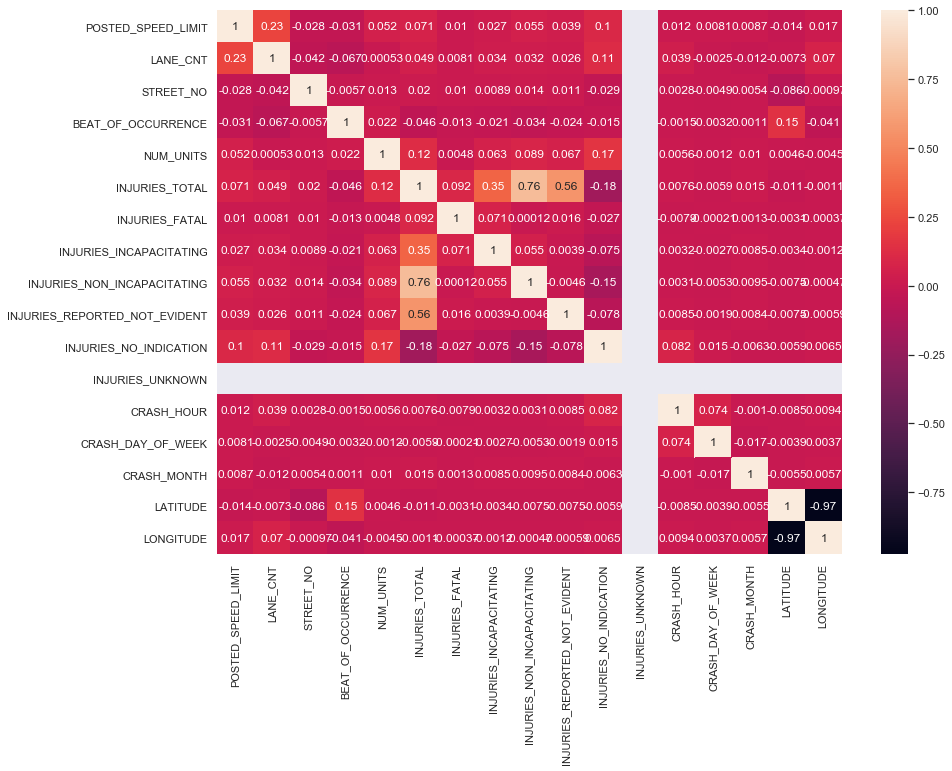

In [70]:
# Correlation heatmap of crashes numerical columns
crashes_c = pd.DataFrame(crashes,columns=crashes.select_dtypes(include=['int', 'float']).columns.tolist())
corrMatrix = crashes_c.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corrMatrix, annot=True)
plt.show()

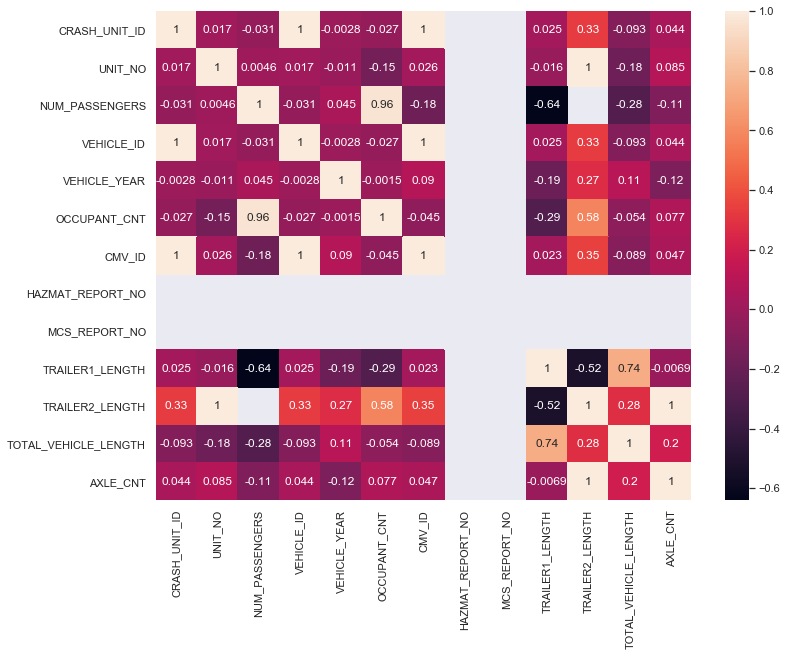

In [71]:
# Correlation heatmap of vehicles numerical columns
vehicles_c = pd.DataFrame(vehicles,columns=vehicles.select_dtypes(include=['int', 'float']).columns.tolist())
corrMatrix = vehicles_c.corr()
plt.figure(figsize=(12, 9))
sns.heatmap(corrMatrix, annot=True)
plt.show()

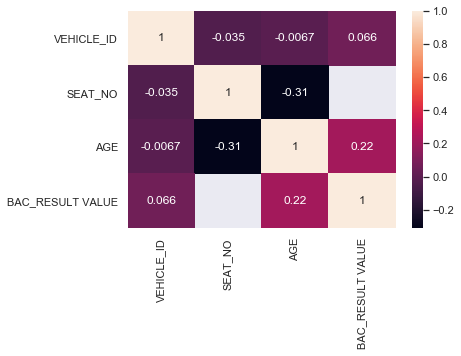

In [72]:
# Correlation heatmap of people numerical columns
people_c = pd.DataFrame(people,columns=people.select_dtypes(include=['int', 'float']).columns.tolist())
corrMatrix = people_c.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [73]:
# Appx ~35 seconds
elapsed = timeit.default_timer() - start_time
print('Runtime of the script is', round(elapsed, 2), 'seconds.')

Runtime of the script is 60.55 seconds.


According to Business Understanding

##### Influencial Feature of crashes are 

CRASH_RECORD_ID, CRASH_DATE, POSTED_SPEED_LIMIT, TRAFFIC_CONTROL_DEVICE, DEVICE_CONDITION, WEATHER_CONDITION, LIGHTING_CONDITION, FIRST_CRASH_TYPE, ROADWAY_SURFACE_COND, ROAD_DEFECT, HIT_AND_RUN_I, DAMAGE, STREET_NAME, LOCATION

#####  Target Feature of crashes are 

CRASH_TYPE, INJURIES_TOTAL

---------------------------------------------------------------------------

##### Influencial Feature of people are 

PERSON_TYPE, CRASH_DATE, CITY, STATE, ZIPCODE, SEX, AGE, SAFETY_EQUIPMENT, AIRBAG_DEPLOYED, INJURY_CLASSIFICATION

#####  Target Feature of people is 

INJURY_CLASSIFICATION

---------------------------------------------------------------------------

##### Influencial Feature of vehicle are 

CRASH_RECORD_ID, CRASH_DATE, UNIT_TYPE, NUM_PASSENGERS, MAKE, VEHICLE_YEAR, VEHICLE_TYPE, OCCUPANT_CNT, 

#####  Target Feature of vehicle is 

Also should be injuries by connecting the datasets via CRASH_RECORD_ID

